Recommendation System Project

**Problem Statement** -
Build your own recommendation system for products on an e-commerce website like Amazon.com.

**Dataset Link** -
https://drive.google.com/file/d/1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW/view?usp=sharing

In [7]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
# Read and explore the given dataset. ( Rename column/add headers, plot histograms, find data characteristics)
columns = ['userId', 'productId', 'ratings', 'timestamp']
ratingsdf = pd.read_csv("/Volumes/Activeai-drive/GL-ALML-drive/ratings_Electronics.csv",names= columns)

In [56]:
ratingsdf.tail(5)

,userId,productId,ratings,timestamp
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824478,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200
7824481,A2G81TMIOIDEQQ,BT008V9J9U,5.0,1312675200


In [57]:
ratingsdf.info()

## 7824482 entries all total

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
productId    object
ratings      float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [58]:
rating_range =ratingsdf['ratings'].unique()
sorted(rating_range)

[1.0, 2.0, 3.0, 4.0, 5.0]

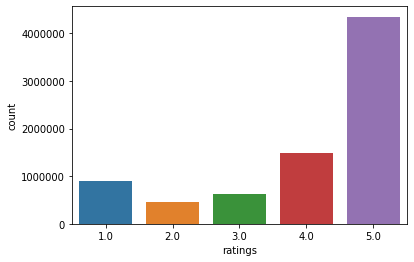

In [59]:
sns.countplot(ratingsdf['ratings'])

# high number of reviews of 5, could be fould play
# lets make it sparse/or spread right

In [60]:
# select those rows for those users who have atleast given 5 reviews
# a = ratingsdf.groupby('userId')['ratings'].size()
# a[ a > 50][0]

a = ratingsdf.groupby('userId').size().loc[lambda x: x>=50].sort_values()

In [61]:
ratingsdf = ratingsdf[ratingsdf['userId'].isin(a.keys())]

In [62]:
## the data is now reduced significantly and only those user's who have given atleast 50 reviews were choosen

ratingsdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125871 entries, 94 to 7824444
Data columns (total 4 columns):
userId       125871 non-null object
productId    125871 non-null object
ratings      125871 non-null float64
timestamp    125871 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.8+ MB


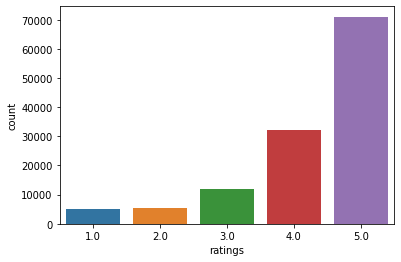

In [63]:
sns.countplot(ratingsdf['ratings'])

In [76]:
mean_rating = pd.DataFrame(ratingsdf.groupby('productId')['ratings'].mean()) 
mean_rating.head()

,ratings
productId,
0594451647,5.000000
0594481813,3.000000
0970407998,2.500000
0972683275,4.750000
1400501466,3.333333


In [77]:
mean_rating['counts'] = pd.DataFrame(ratingsdf.groupby('productId')['ratings'].count())

In [78]:
mean_rating.head()

,ratings,counts
productId,,
0594451647,5.000000,1
0594481813,3.000000,1
0970407998,2.500000,2
0972683275,4.750000,4
1400501466,3.333333,6


In [83]:
def weighted_rating(mean_rating, min_rate, mean_rating_df):
    weighted_rating = list()
    V = mean_rating.counts.values
    R = mean_rating.ratings.values
    for v, r in zip(V, R):
        if v < 5:
            weighted_rating.append(0)
        else:
            weighted_rating.append((v/(v+min_rate))*r + (min_rate/(v+min_rate))*mean_rating_df)
    return(weighted_rating)

In [84]:
mean_rating['wr'] = weighted_rating(mean_rating, 5, np.mean(mean_rating.ratings.values))

In [86]:
mean_rating.head()

,ratings,counts,wr
productId,,,
0594451647,5.000000,1,0.000000
0594481813,3.000000,1,0.000000
0970407998,2.500000,2,0.000000
0972683275,4.750000,4,0.000000
1400501466,3.333333,6,3.734045


In [87]:
mean_rating.wr.sort_values(ascending = False).head(10)
# Popular products to be recommended are 

productId
B0052SCU8U    4.908787
B003ES5ZUU    4.846955
B001TH7T2U    4.846100
B00BQ4F9ZA    4.841490
B000FQ2JLW    4.836437
B001TH7GUU    4.832223
B003ES5ZR8    4.830700
B0046TJG1U    4.830155
B00ISFNSBW    4.829326
B0019EHU8G    4.821837
Name: wr, dtype: float64

In [102]:
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import Dataset
from surprise import Reader

In [90]:
ratingsdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125871 entries, 94 to 7824444
Data columns (total 4 columns):
userId       125871 non-null object
productId    125871 non-null object
ratings      125871 non-null float64
timestamp    125871 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 9.8+ MB


In [134]:
tempdf = pd.DataFrame(data={'userId':ratingsdf.userId,
                            'productId':ratingsdf.productId,                           
                           'ratings':ratingsdf.ratings})
tempdf.head()

,userId,productId,ratings
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [135]:
reader = Reader(rating_scale=(1, 5))
X_train, X_test = train_test_split(Dataset.load_from_df(tempdf, reader), test_size=.30)

In [136]:
# lets use K-NN with Means which takes in account the mean ratings of each user.
from surprise import KNNWithMeans

In [138]:
model = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
model.fit(X_train)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [139]:
# run model against test data
predictions = model.test(X_test)

# get RMSE 
print("User-based Model")
accuracy.rmse(predictions, verbose=True)
accuracy.mae(predictions, verbose=True)

User-based Model
RMSE: 1.0545
MAE:  0.7762


0.7761631128364307

In [140]:
## Following code taken from http://nbviewer.jupyter.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/KNNBasic_analysis.ipynb


def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(X_train.ur[X_train.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(X_train.ir[X_train.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [141]:
# courtesy the notebook
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
14057,A2AY4YUOX2N1BQ,B00DK2JQOQ,5.0,5.0,"{'actual_k': 9, 'was_impossible': False}",211,15,0.0
22350,A1E1LEVQ9VQNK,B00GTLN1BO,5.0,5.0,"{'actual_k': 5, 'was_impossible': False}",137,6,0.0
7420,A22I55P15NSAOX,B00HMREOLK,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",58,12,0.0
33417,A23WPWLYT3P1CZ,B002SZEOLG,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",40,75,0.0
7424,A370XYLIZCSK1Y,B003FVJYF8,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",77,19,0.0
22335,A2V0I904FH7ABY,B002TLTE6Y,5.0,5.0,"{'actual_k': 7, 'was_impossible': False}",56,19,0.0
22333,AWPODHOB4GFWL,B000RHZJN4,5.0,5.0,"{'actual_k': 5, 'was_impossible': False}",217,11,0.0
22325,AYB4ELCS5AM8P,B00ITIIE2Q,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",114,2,0.0
22323,A328S9RN3U5M68,B003XFWSU4,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",50,6,0.0
1666,A2V5M5EJPOD2IU,B002K23V1Q,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",89,4,0.0


In [142]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
25652,A35HNL2VEDK9Z1,B0099XGZXA,1.0,5.0,"{'actual_k': 2, 'was_impossible': False}",54,7,4.0
30833,A4D5B7Q8A7PA6,B003VAGXWK,1.0,5.0,"{'actual_k': 2, 'was_impossible': False}",80,17,4.0
28553,A3QDMDSANPYGUX,B001TH7GUU,1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",34,56,4.0
33962,ACQYIC13JXAOI,B00IVPU7DG,1.0,5.0,"{'actual_k': 3, 'was_impossible': False}",60,10,4.0
8972,A5KMMY627T3W,B003FW0LR2,1.0,5.0,"{'actual_k': 2, 'was_impossible': False}",97,4,4.0
31952,A2XRMQA6PJ5ZJ8,B0038P1TP4,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",177,5,4.0
28103,A1SHHQSPOWR00F,B004WYA852,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",51,5,4.0
3252,A2ED50E3KWKUKW,B003EB0AXY,1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",46,1,4.0
10188,A16RL0RMRF974O,B005IHAIHA,1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",38,3,4.0
30283,A2JRDFIGWTX50J,B0002ZW5W4,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",33,6,4.0
